# Time Series Forecasting: U.S. Retail Sales

This notebook implements a comprehensive time series forecasting approach using traditional statistical models, machine learning algorithms, deep learning neural networks, and ensemble techniques to predict U.S. retail sales.

In [2]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# FRED API
from fredapi import Fred

# Time series analysis
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Deep Learning - LSTM (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Statistical functions
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar
from scipy.stats import boxcox, shapiro
from scipy.special import inv_boxcox

## Data Preparation

### Clean and Preprocess Dataset
- Load data from FRED API
- Handle missing values
- Split into training and test sets
- Test for stationarity

In [3]:
# Load Data from FRED (Federal Reserve Economic Data)
FRED_API_KEY = '02f08202e42af0f286dc321afe6da9ee'
fred = Fred(api_key=FRED_API_KEY)

# Fetch U.S. Advance Retail Sales data (RSXFS - Monthly, Not Seasonally Adjusted)
# Get last 10 years of data for more robust analysis
from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

series_id = 'RSXFS'
sales_data = fred.get_series(series_id, observation_start=start_date.strftime('%Y-%m-%d'))
sales_data = sales_data.to_frame(name='Units ordered')

# Load meaningful exogenous variables from FRED to improve forecasting accuracy
# These variables influence retail sales and provide additional predictive power

# 1. CPI (Consumer Price Index) - measures inflation
cpi_data = fred.get_series('CPIAUCSL', observation_start=start_date.strftime('%Y-%m-%d'))

# 2. Unemployment Rate - labor market health impacts consumer spending
unemployment_data = fred.get_series('UNRATE', observation_start=start_date.strftime('%Y-%m-%d'))

# 3. Consumer Sentiment - consumer confidence affects retail purchases
sentiment_data = fred.get_series('UMCSENT', observation_start=start_date.strftime('%Y-%m-%d'))

# Combine all data into a single dataframe
sales_data['CPI'] = cpi_data
sales_data['Unemployment'] = unemployment_data
sales_data['Sentiment'] = sentiment_data

# Forward-fill any missing values (common for monthly data alignment)
sales_data = sales_data.fillna(method='ffill').fillna(method='bfill')

Missing values: 0


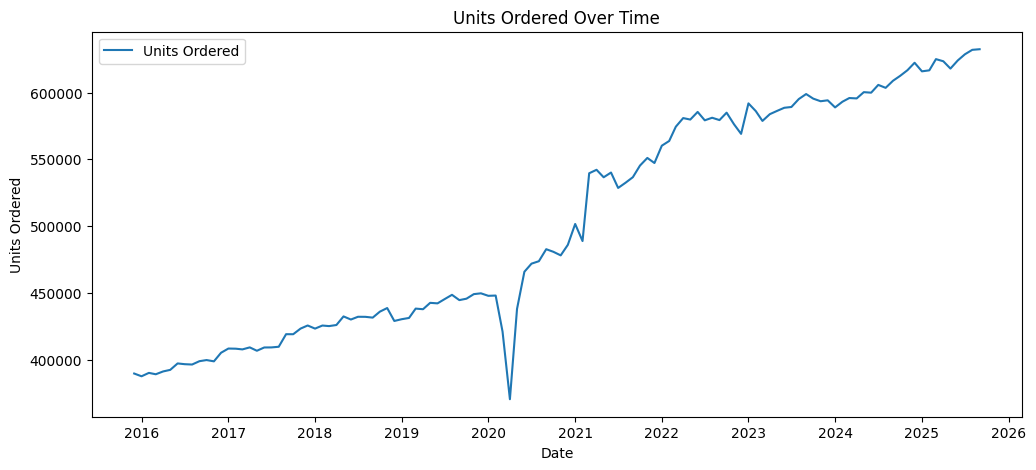

In [4]:
# Check for missing values
print(f"Missing values: {sales_data.isnull().sum().sum()}")

# Plot the raw data
plt.figure(figsize=(12,5))
plt.plot(sales_data.index, sales_data['Units ordered'], label='Units Ordered')
plt.title('Units Ordered Over Time')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.show()

Training: 94 obs (2015-12-01 00:00:00 to 2023-09-01 00:00:00)
Test: 24 obs (2023-10-01 00:00:00 to 2025-09-01 00:00:00)


Text(0.5, 1.0, 'Units Ordered: Training and Test Sets')

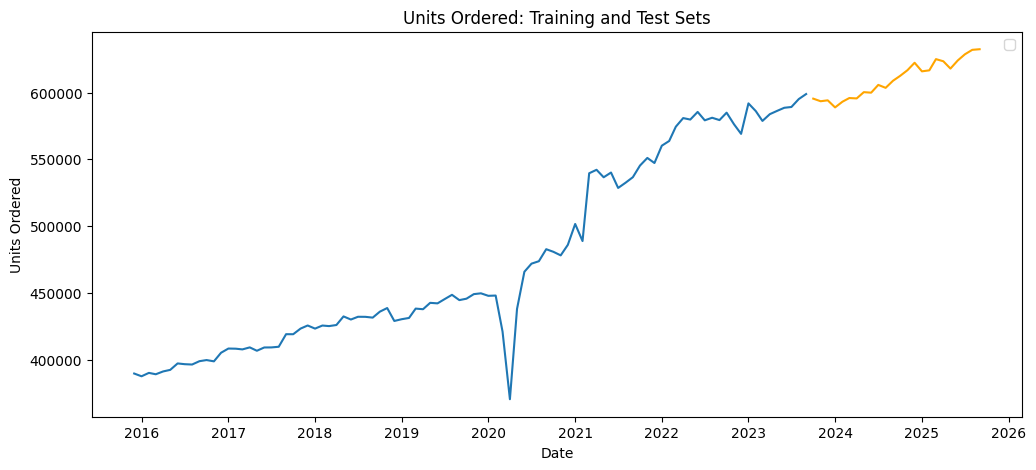

In [5]:
# Train/Test Split (80/20)
n_obs = len(sales_data)
train_size = int(n_obs * 0.8)
train = sales_data.iloc[:train_size].copy()
test = sales_data.iloc[train_size:].copy()

print(f"Training: {len(train)} obs ({train.index[0]} to {train.index[-1]})")
print(f"Test: {len(test)} obs ({test.index[0]} to {test.index[-1]})")

plt.show()

plt.figure(figsize=(12,5))
plt.legend()

plt.plot(train.index, train['Units ordered'], label='Training Set')
plt.ylabel('Units Ordered')

plt.plot(test.index, test['Units ordered'], label='Test Set', color='orange')
plt.xlabel('Date')
plt.title('Units Ordered: Training and Test Sets')

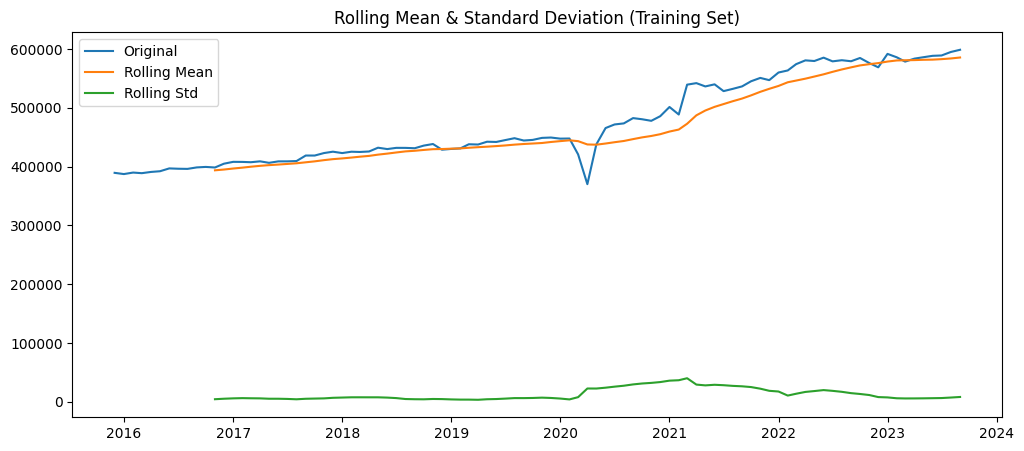

ORIGINAL SERIES ADF TEST
ADF Statistic: 0.03788924866296303
p-value: 0.9615555664442459

FIRST DIFFERENCING
ADF Statistic after differencing: -8.72430552713228
p-value after differencing: 3.32044917434809e-14

Final decision: ARIMA(p,1,q) with d=1 for differencing order


In [6]:
# Diagnostics: Variance stability and stationarity (training data only)

# Plot rolling mean and standard deviation
window = 12  # 1 year for monthly data (12 months)
rolling_mean = train['Units ordered'].rolling(window=window).mean()  # Calculate rolling mean
rolling_std = train['Units ordered'].rolling(window=window).std()  # Calculate rolling std

plt.figure(figsize=(12,5))  # Set figure size
plt.plot(train['Units ordered'], label='Original')  # Plot original series
plt.plot(rolling_mean, label='Rolling Mean')  # Plot rolling mean
plt.plot(rolling_std, label='Rolling Std')  # Plot rolling std
plt.title('Rolling Mean & Standard Deviation (Training Set)')  # Set plot title
plt.legend()  # Show legend
plt.show()  # Display plot

# Augmented Dickey-Fuller (ADF) test for stationarity
print('ORIGINAL SERIES ADF TEST')
adf_result = adfuller(train['Units ordered'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# First differencing
print('\nFIRST DIFFERENCING')
units_diff = train['Units ordered'].diff().dropna()
adf_diff = adfuller(units_diff)
print(f'ADF Statistic after differencing: {adf_diff[0]}')
print(f'p-value after differencing: {adf_diff[1]}')

# Check if first differencing is sufficient
if adf_diff[1] <= 0.05:
    d_order = 1
    units_diff_final = units_diff
else:
    # Second-order differencing
    print('\nSECOND-ORDER DIFFERENCING')
    units_diff2 = train['Units ordered'].diff().diff().dropna()
    adf_diff2 = adfuller(units_diff2)
    print(f'ADF Statistic after 2nd differencing: {adf_diff2[0]}')
    print(f'p-value after 2nd differencing: {adf_diff2[1]}')
    
    if adf_diff2[1] <= 0.05:
        d_order = 2
        units_diff_final = units_diff2
    else:
        d_order = 2  # Use d=2 even if not fully stationary
        units_diff_final = units_diff2

print(f'\nFinal decision: ARIMA(p,{d_order},q) with d={d_order} for differencing order')

In [7]:
# Apply appropriate differencing to the training and test data based on stationarity test results
if d_order == 1:
    train_transformed = train['Units ordered'].diff().dropna()
    test_transformed = test['Units ordered'].diff().dropna()
    transformation = 'first differencing'
else:  # d_order == 2
    train_transformed = train['Units ordered'].diff().diff().dropna()
    test_transformed = test['Units ordered'].diff().diff().dropna()
    transformation = 'second-order differencing'

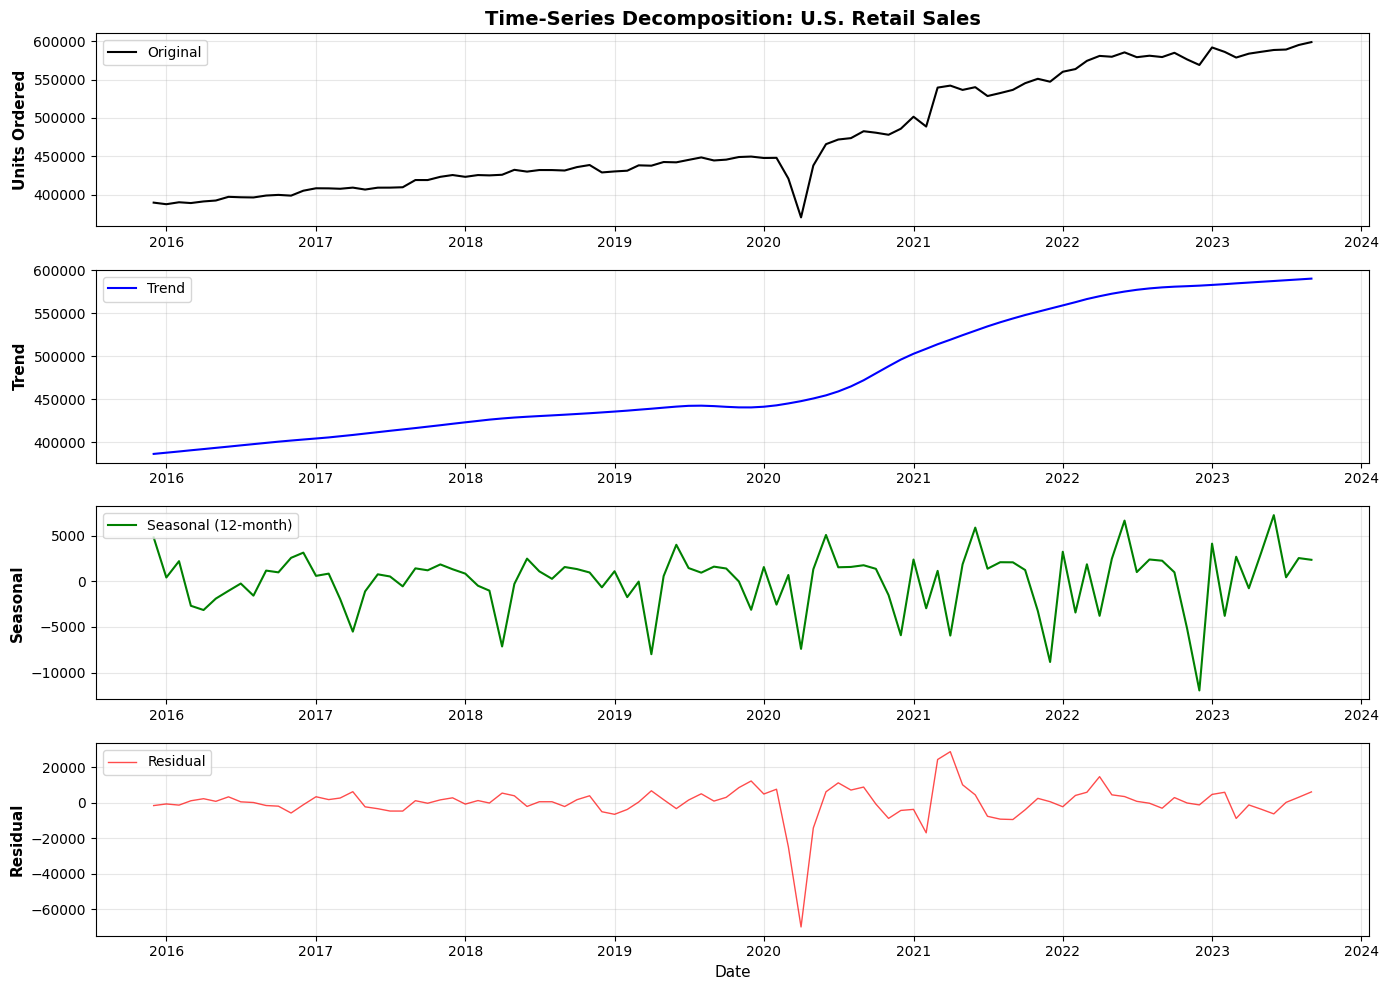

In [21]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition (Seasonal and Trend decomposition using Loess)
stl = STL(train['Units ordered'], seasonal=13)  # seasonal=13 for monthly data
result = stl.fit()

# Create comprehensive decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Original series
axes[0].plot(train.index, train['Units ordered'], label='Original', color='black', linewidth=1.5)
axes[0].set_ylabel('Units Ordered', fontsize=11, fontweight='bold')
axes[0].set_title('Time-Series Decomposition: U.S. Retail Sales', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Trend component
axes[1].plot(train.index, result.trend, label='Trend', color='blue', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Seasonal component (12-month periodicity)
axes[2].plot(train.index, result.seasonal, label='Seasonal (12-month)', color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# Residual component
axes[3].plot(train.index, result.resid, label='Residual', color='red', linewidth=1, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11)
axes[3].legend(loc='upper left')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Engineering
- Create lag variables (1-12 months)
- Generate rolling statistics (mean, std, min, max)
- Add seasonal indicators (month, quarter)
- Incorporate external data (holidays, macroeconomic indicators)
- Create cyclical encodings for temporal features

In [8]:
# Enhanced Feature Engineering for Machine Learning Models
# WHY: ML models need evolving features to avoid flat-line predictions
# Including lag features AND exogenous variables for comprehensive modeling

def create_ml_features(data, target_col='Units ordered'):
    df = pd.DataFrame(index=data.index)
    df['target'] = data[target_col]
    
    # 1. LAG FEATURES (key periods only)
    for lag in [1, 3, 6, 12]:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    
    # 2. ROLLING MEANS (two key windows)
    for window in [3, 12]:
        df[f'rolling_mean_{window}'] = df['target'].shift(1).rolling(window=window).mean()
    
    # 3. MONTH INDICATOR (seasonal patterns)
    df['month'] = df.index.month
    
    # 4. TREND FEATURE (overall direction)
    df['trend'] = np.arange(len(df))
    
    # 5. HOLIDAY INDICATOR (US Federal Holidays)
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.isin(holidays).astype(int)
    
    # 6. EXOGENOUS VARIABLES - CRITICAL FOR NON-FLAT FORECASTS
    # These variables change each month and provide real-world context
    if 'CPI' in data.columns:
        df['CPI'] = data['CPI']
    if 'Unemployment' in data.columns:
        df['Unemployment'] = data['Unemployment']
    if 'Sentiment' in data.columns:
        df['Sentiment'] = data['Sentiment']
    
    return df


# Create features
train_ml_features = create_ml_features(train)
test_ml_features = create_ml_features(test)

# Drop rows with NaN (due to lag/rolling features)
train_ml_features_clean = train_ml_features.dropna()
test_ml_features_clean = test_ml_features.dropna()

print(f"Training samples after feature engineering: {len(train_ml_features_clean)}")
print(f"Test samples after feature engineering: {len(test_ml_features_clean)}")
print(f"Number of features: {len(train_ml_features_clean.columns) - 1}")  # -1 for target

# Separate features and target
X_train_ml = train_ml_features_clean.drop('target', axis=1)
y_train_ml = train_ml_features_clean['target']
X_test_ml = test_ml_features_clean.drop('target', axis=1)
y_test_ml = test_ml_features_clean['target']

print(f"\nFeatures used: {list(X_train_ml.columns)}")
print(f"\nExogenous variables included: CPI, Unemployment, Sentiment")

Training samples after feature engineering: 82
Test samples after feature engineering: 12
Number of features: 12

Features used: ['lag_1', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_12', 'month', 'trend', 'is_holiday', 'CPI', 'Unemployment', 'Sentiment']

Exogenous variables included: CPI, Unemployment, Sentiment


In [9]:
# Recursive Forecasting Function for ML Models
# Prevents flat-line forecasts by updating features dynamically at each prediction step

def recursive_forecast(model, last_train_row, full_data, n_steps, feature_names, scaler=None):

    predictions = []
    
    # Start with historical data
    history = full_data['Units ordered'].copy()
    
    # Get exogenous variables for test period (these are known future values)
    exog_vars = ['CPI', 'Unemployment', 'Sentiment']
    
    for step in range(n_steps):
        # Calculate current date
        current_date = last_train_row.name + pd.DateOffset(months=step+1)
        
        # Build feature vector for current step
        features = {}
        
        # Lag features - use most recent history
        features['lag_1'] = history.iloc[-1]
        features['lag_3'] = history.iloc[-3] if len(history) >= 3 else history.iloc[0]
        features['lag_6'] = history.iloc[-6] if len(history) >= 6 else history.iloc[0]
        features['lag_12'] = history.iloc[-12] if len(history) >= 12 else history.iloc[0]
        
        # Rolling means - calculate from recent history
        features['rolling_mean_3'] = history.iloc[-3:].mean() if len(history) >= 3 else history.mean()
        features['rolling_mean_12'] = history.iloc[-12:].mean() if len(history) >= 12 else history.mean()
        
        # Temporal features
        features['month'] = current_date.month
        features['trend'] = len(history)
        
        # Holiday indicator
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=current_date, end=current_date)
        features['is_holiday'] = 1 if current_date in holidays else 0
        
        # Exogenous variables - get from future data (these are known)
        if current_date in full_data.index:
            for var in exog_vars:
                if var in full_data.columns:
                    features[var] = full_data.loc[current_date, var]
        
        # Create feature array in correct order
        X_current = np.array([[features[f] for f in feature_names]])
        
        # Scale if needed (for neural networks)
        if scaler is not None:
            X_current = scaler.transform(X_current)
        
        # Predict next value
        pred = model.predict(X_current)[0]
        predictions.append(pred)
        
        # CRITICAL: Add prediction to history for next iteration
        # This is what prevents flat-line forecasts
        history = pd.concat([history, pd.Series([pred], index=[current_date])])
    
    return predictions

## Model Development

### Traditional Models
Implement ETS and ARIMA models, including ARIMAX with exogenous variables.

ETS Model Parameters:
Alpha (level): 1.0000
Beta (trend): 0.0283
Gamma (seasonal): 0.0000


c:\Users\pawem\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


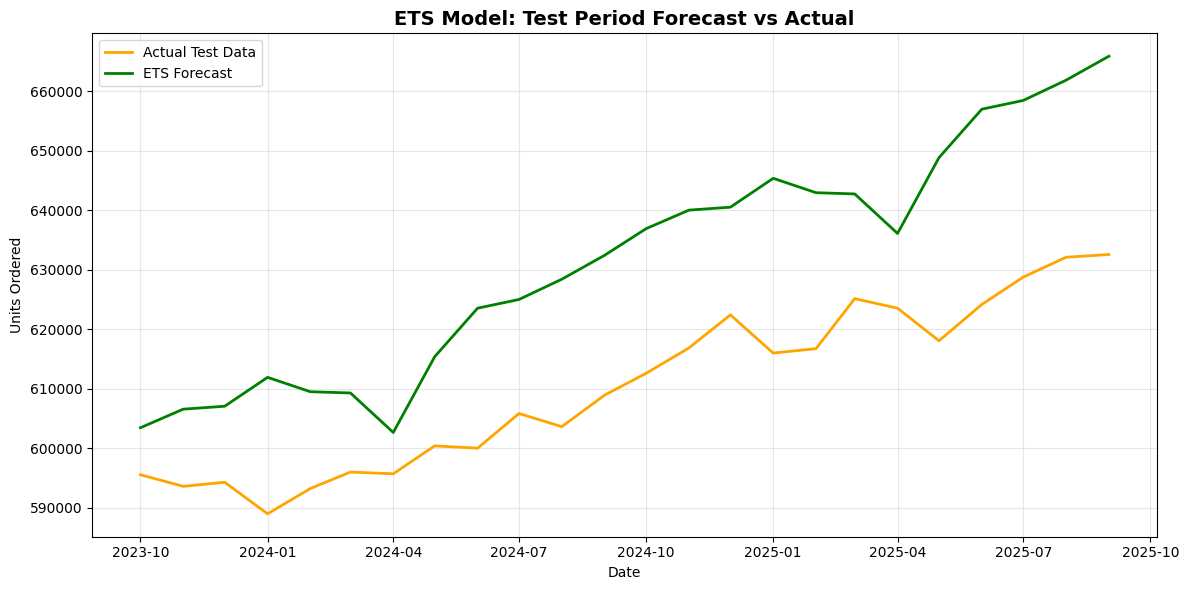

In [10]:
# ETS Model (Exponential Smoothing State Space Model)

# Fit ETS model with 12-month seasonality
start_time = time.time()

ets_model_new = ExponentialSmoothing(
    train['Units ordered'], 
    trend='add',      # Additive trend
    seasonal='add',   # Additive seasonality
    seasonal_periods=12  # Monthly seasonality (12 months per year)
).fit()

print("ETS Model Parameters:")
print(f"Alpha (level): {ets_model_new.params['smoothing_level']:.4f}")
print(f"Beta (trend): {ets_model_new.params['smoothing_trend']:.4f}")
print(f"Gamma (seasonal): {ets_model_new.params['smoothing_seasonal']:.4f}")

# Generate forecasts for test period
ets_forecast_new = ets_model_new.forecast(steps=len(test))
ets_forecast_new.index = test.index

# If still getting NaN, try the fitted values approach
if ets_forecast_new.isna().all():
    # Use simulate method instead
    ets_forecast_new = ets_model_new.simulate(
        nsimulations=len(test),
        anchor='end',
        random_errors='bootstrap'
    )
ets_forecast_new = ets_model_new.forecast(steps=len(test))
ets_forecast_new.index = test.index

# Visualization: ETS Model Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(test.index, ets_forecast_new, label='ETS Forecast', color='green', linewidth=2)
plt.title('ETS Model: Test Period Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


c:\Users\pawem\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pawem\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



SARIMA Model Parameters:
Non-seasonal order (p,d,q): (1, 1, 1)
Seasonal order (P,D,Q,s): (1, 1, 1, 12)
AIC: 1508.05
BIC: 1519.07


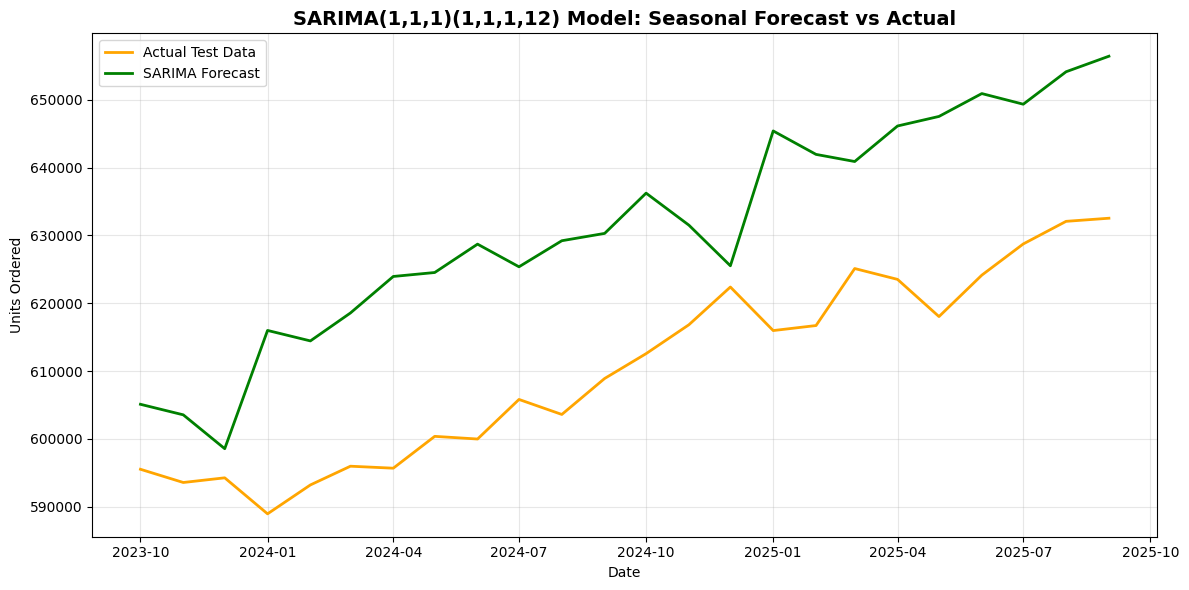


✓ SARIMA forecast complete - should show seasonal patterns, not flat line


In [11]:
# SARIMA Model Implementation (Seasonal ARIMA)
# WHY SARIMA INSTEAD OF ARIMA:
# - The data shows strong 12-month seasonal patterns (retail peaks in holidays)
# - ARIMA(1,1,1) failed because it couldn't capture this seasonality

start_time = time.time()

# Fit SARIMA model with seasonal components
# order=(1,d,1): non-seasonal AR(1), differencing(d), MA(1)
# seasonal_order=(1,1,1,12): seasonal AR(1), seasonal differencing(1), seasonal MA(1), 12-month period
sarima_model = SARIMAX(
    train['Units ordered'], 
    order=(1, d_order, 1),
    seasonal_order=(1, 1, 1, 12),  # KEY: 12-month seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fitted = sarima_model.fit(disp=False)

print(f"\nSARIMA Model Parameters:")
print(f"Non-seasonal order (p,d,q): (1, {d_order}, 1)")
print(f"Seasonal order (P,D,Q,s): (1, 1, 1, 12)")
print(f"AIC: {sarima_fitted.aic:.2f}")
print(f"BIC: {sarima_fitted.bic:.2f}")

# Generate forecasts
sarima_forecast = sarima_fitted.forecast(steps=len(test))
sarima_forecast.index = test.index

# Visualization: SARIMA Model Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linewidth=2)
plt.title(f'SARIMA(1,{d_order},1)(1,1,1,12) Model: Seasonal Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ SARIMA forecast complete - should show seasonal patterns, not flat line")

c:\Users\pawem\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pawem\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX Model Parameters:
Non-seasonal order (p,d,q): (1, 1, 1)
Seasonal order (P,D,Q,s): (1, 1, 1, 12)
Exogenous variables: 9
AIC: 1475.52


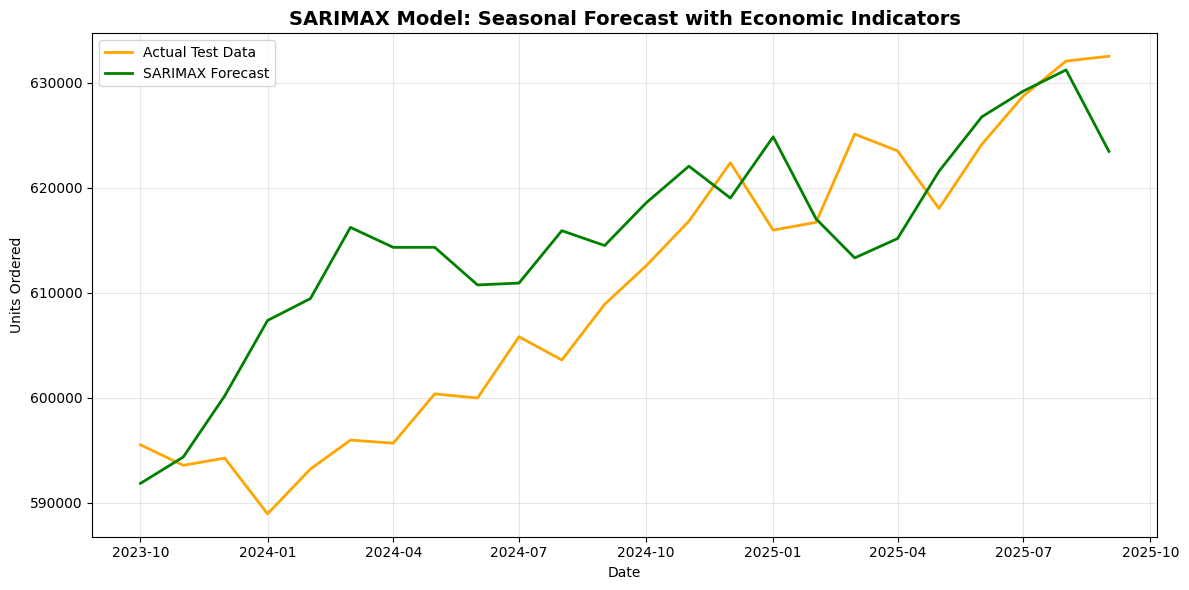

In [12]:
# SARIMAX Model Implementation (SARIMA with Exogenous Variables)
# WHY SARIMAX:
# - Combines seasonal modeling with external economic indicators
# - CPI, unemployment, and sentiment provide additional predictive power

# Prepare exogenous variables for SARIMAX
def create_exog_features(data_index, data):
    """Create exogenous features including economic indicators"""
    exog = pd.DataFrame(index=data_index)
    
    # Date features
    exog['month'] = data_index.month
    exog['day_of_week'] = data_index.dayofweek
    exog['is_weekend'] = (data_index.dayofweek >= 5).astype(int)
    exog['quarter'] = data_index.quarter
    exog['trend'] = np.arange(len(data_index))
    
    # Holiday indicator
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data_index.min(), end=data_index.max())
    exog['is_holiday'] = data_index.isin(holidays).astype(int)
    
    # CRITICAL: Add exogenous economic variables
    # These change monthly and help prevent flat-line forecasts
    if 'CPI' in data.columns:
        exog['CPI'] = data.loc[data_index, 'CPI'].values
    if 'Unemployment' in data.columns:
        exog['Unemployment'] = data.loc[data_index, 'Unemployment'].values
    if 'Sentiment' in data.columns:
        exog['Sentiment'] = data.loc[data_index, 'Sentiment'].values
    
    return exog

# Create exogenous variables
exog_train = create_exog_features(train.index, train)
exog_test = create_exog_features(test.index, test)

start_time = time.time()

# Fit SARIMAX with seasonal components AND exogenous variables
sarimax_model = SARIMAX(
    train['Units ordered'], 
    exog=exog_train,
    order=(1, d_order, 1),
    seasonal_order=(1, 1, 1, 12),  # 12-month seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fitted = sarimax_model.fit(disp=False)

print(f"SARIMAX Model Parameters:")
print(f"Non-seasonal order (p,d,q): (1, {d_order}, 1)")
print(f"Seasonal order (P,D,Q,s): (1, 1, 1, 12)")
print(f"Exogenous variables: {exog_train.shape[1]}")
print(f"AIC: {sarimax_fitted.aic:.2f}")

# Generate forecasts
sarimax_forecast = sarimax_fitted.forecast(steps=len(test), exog=exog_test)
sarimax_forecast.index = test.index

# Visualization: SARIMAX Model Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='green', linewidth=2)
plt.title('SARIMAX Model: Seasonal Forecast with Economic Indicators', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Machine Learning Models
Implement gradient boosting (XGBoost, LightGBM) and tree-based models (Random Forest).

Random Forest Parameters:
n_estimators: 100
max_depth: 15
Features used: 12

Top 10 Most Important Features:
            feature  importance
1             lag_3    0.197715
7             trend    0.179185
5   rolling_mean_12    0.152498
9               CPI    0.116705
2             lag_6    0.115992
0             lag_1    0.097889
4    rolling_mean_3    0.096671
3            lag_12    0.023994
10     Unemployment    0.015375
11        Sentiment    0.003118


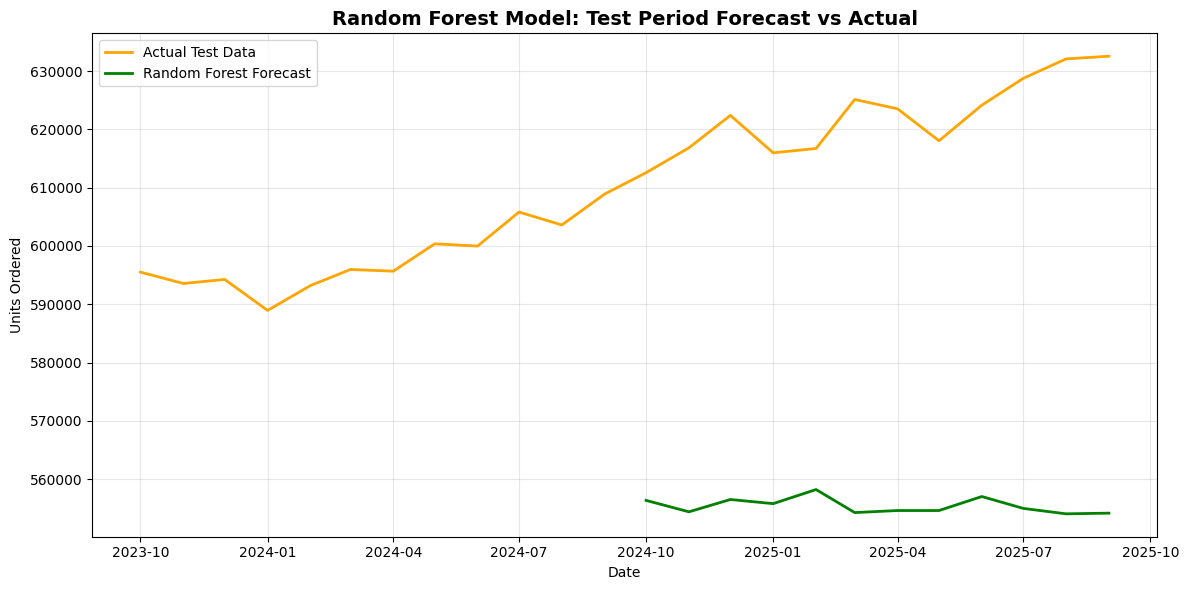

In [13]:
# Random Forest Model

from sklearn.ensemble import RandomForestRegressor

start_time = time.time()

# Initialize and train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,        # Number of trees
    max_depth=15,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split node
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,
    n_jobs=-1,               # Use all available cores
    verbose=0
)

rf_model.fit(X_train_ml, y_train_ml)

print("Random Forest Parameters:")
print(f"n_estimators: {rf_model.n_estimators}")
print(f"max_depth: {rf_model.max_depth}")
print(f"Features used: {X_train_ml.shape[1]}")

# Generate predictions
rf_forecast = rf_model.predict(X_test_ml)
rf_forecast = pd.Series(rf_forecast, index=y_test_ml.index, name='RF_Forecast')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_ml.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualization: Random Forest Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(rf_forecast.index, rf_forecast, label='Random Forest Forecast', color='green', linewidth=2)
plt.title('Random Forest Model: Test Period Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


XGBoost Parameters:
n_estimators: 100
max_depth: 6
learning_rate: 0.1


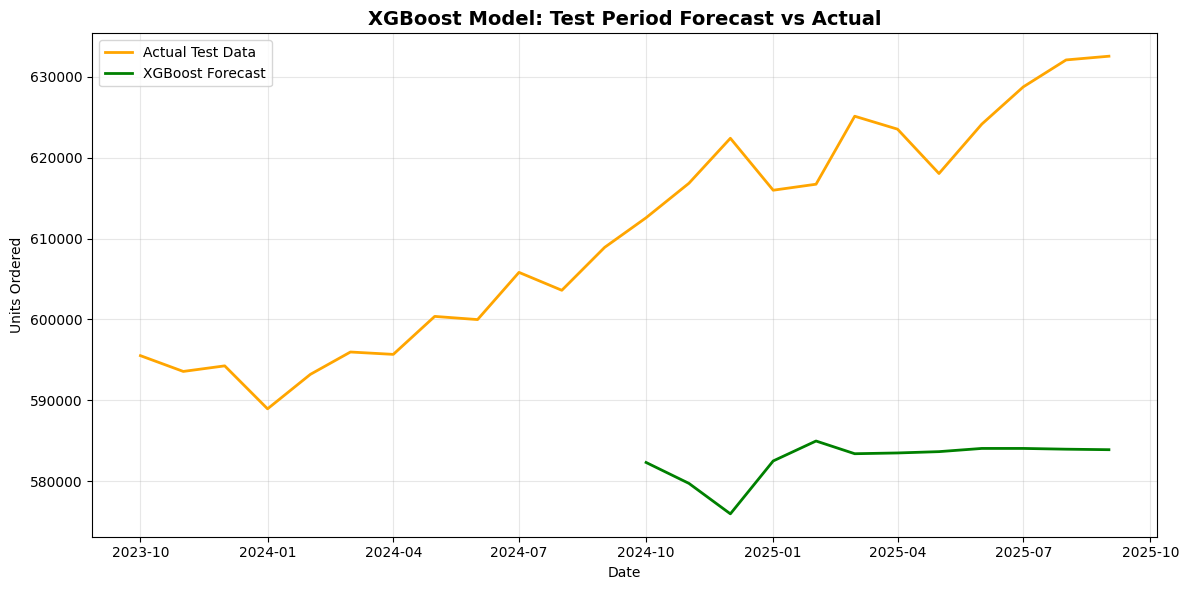

In [14]:
# XGBoost Model

from xgboost import XGBRegressor

start_time = time.time()

# Initialize and train XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train_ml, y_train_ml)

print("XGBoost Parameters:")
print(f"n_estimators: {xgb_model.n_estimators}")
print(f"max_depth: {xgb_model.max_depth}")
print(f"learning_rate: {xgb_model.learning_rate}")

# Generate predictions
xgb_forecast = xgb_model.predict(X_test_ml)
xgb_forecast = pd.Series(xgb_forecast, index=y_test_ml.index, name='XGB_Forecast')

# Visualization: XGBoost Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(xgb_forecast.index, xgb_forecast, label='XGBoost Forecast', color='green', linewidth=2)
plt.title('XGBoost Model: Test Period Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Parameters:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1


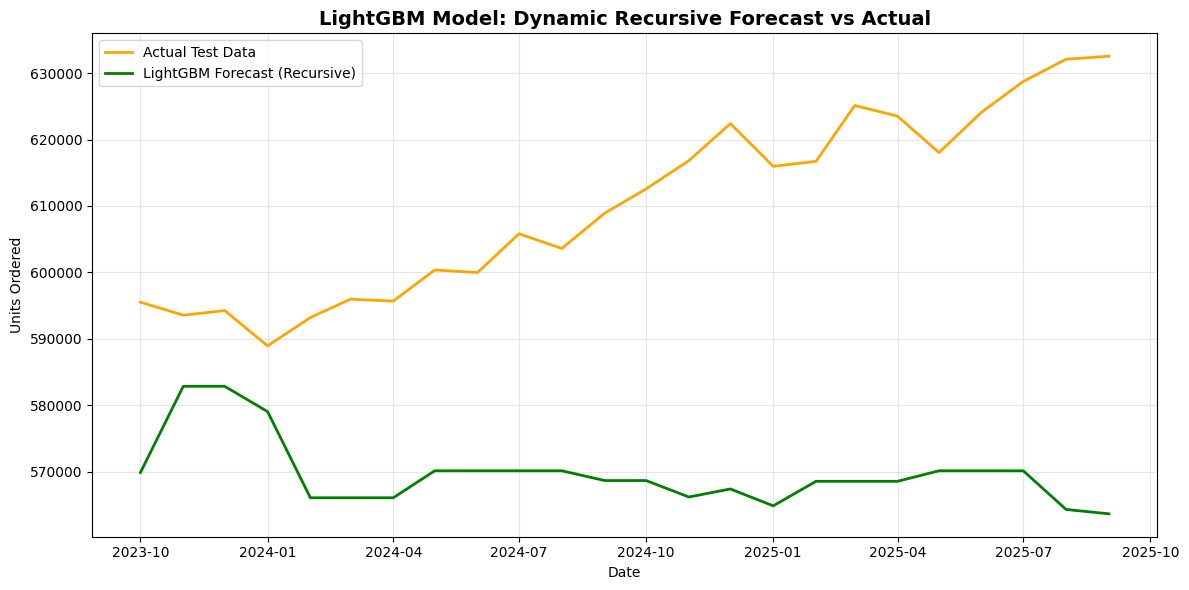

In [15]:
# LightGBM Model with RECURSIVE FORECASTING

from lightgbm import LGBMRegressor

start_time = time.time()

# Initialize and train LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm_model.fit(X_train_ml, y_train_ml)

print(f"Parameters:")
print(f"  n_estimators: {lgbm_model.n_estimators}")
print(f"  max_depth: {lgbm_model.max_depth}")
print(f"  learning_rate: {lgbm_model.learning_rate}")

# USE RECURSIVE FORECASTING instead of static predictions

# Get combined data for recursive forecasting
full_data = pd.concat([train, test])

# Generate recursive predictions
lgbm_forecast_recursive = recursive_forecast(
    model=lgbm_model,
    last_train_row=X_train_ml.iloc[-1],
    full_data=full_data,
    n_steps=len(test),
    feature_names=list(X_train_ml.columns),
    scaler=None  # LightGBM doesn't need scaling
)

# Align predictions with test dates (accounting for dropped rows due to lags)
test_dates = test.index[len(test) - len(lgbm_forecast_recursive):]
lgbm_forecast = pd.Series(lgbm_forecast_recursive, index=test_dates, name='LGBM_Forecast')

# Visualization: LightGBM Forecast (Test Period Only)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(lgbm_forecast.index, lgbm_forecast, label='LightGBM Forecast (Recursive)', color='green', linewidth=2)
plt.title('LightGBM Model: Dynamic Recursive Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Deep Learning Models
Implement recurrent neural networks using LSTM (Long Short-Term Memory) with PyTorch.

LSTM Parameters:
  Sequence length: 12
  Hidden layers: 64, 32 units
  Dropout: 0.2
  Total parameters: 29729


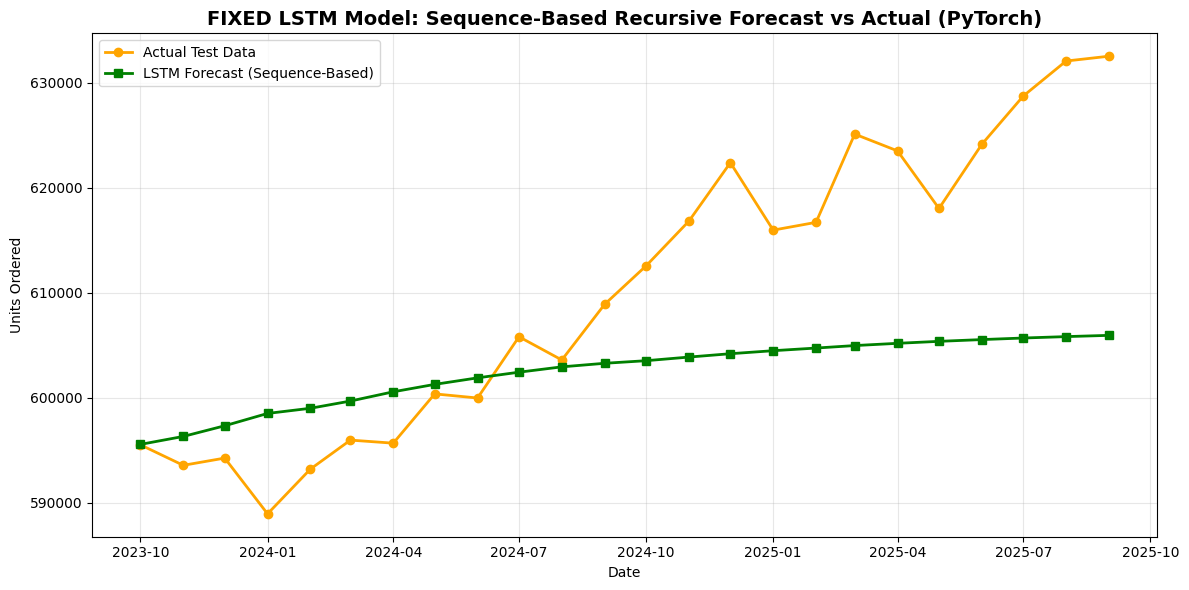

In [16]:
# LSTM Neural Network Model - FIXED IMPLEMENTATION (PyTorch)
# Using proper sequence-based approach with sliding windows

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

start_time = time.time()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 1. PREPARE DATA - Use only the target variable "Units ordered"
train_values = train['Units ordered'].values.reshape(-1, 1)
test_values = test['Units ordered'].values.reshape(-1, 1)

# 2. SCALE THE DATA (fit on training data only)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# 3. CREATE SUPERVISED SEQUENCES (sliding windows)
def create_sequences(data, seq_length):
    """
    Convert time series into supervised learning format
    X: sequences of seq_length time steps
    y: the next value after each sequence
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12  # Use 12 months (1 year) as lookback window

X_train_seq, y_train_seq = create_sequences(train_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(test_scaled, SEQ_LENGTH)

# 4. RESHAPE FOR LSTM: (samples, timesteps, features)
# PyTorch LSTM needs 3D input: [batch_size, seq_length, input_size]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1)

# 5. BUILD LSTM MODEL IN PYTORCH
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size1=64, hidden_size2=32, output_size=1):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        
        # Output layer
        self.fc = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.dropout1(lstm_out1)
        
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)
        
        # Take last time step output
        out = self.fc(lstm_out2[:, -1, :])
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMModel().to(device)

print("LSTM Parameters:")
print(f"  Sequence length: {SEQ_LENGTH}")
print(f"  Hidden layers: 64, 32 units")
print(f"  Dropout: 0.2")
print(f"  Total parameters: {sum(p.numel() for p in lstm_model.parameters())}")

# 6. TRAIN THE MODEL
# Split into train and validation
val_split = int(0.9 * len(X_train_tensor))
X_train_split = X_train_tensor[:val_split].to(device)
y_train_split = y_train_tensor[:val_split].to(device)
X_val_split = X_train_tensor[val_split:].to(device)
y_val_split = y_train_tensor[val_split:].to(device)

# Create data loader
train_dataset = TensorDataset(X_train_split, y_train_split)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    lstm_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_val_split)
        val_loss = criterion(val_outputs, y_val_split).item()
        val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = lstm_model.state_dict().copy()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        break

# Restore best model
lstm_model.load_state_dict(best_model_state)

# 7. RECURSIVE FORECASTING
# Start with the last SEQ_LENGTH values from training data
last_sequence = train_scaled[-SEQ_LENGTH:].copy()

predictions_scaled = []

lstm_model.eval()
with torch.no_grad():
    for i in range(len(test)):
        # Reshape sequence for prediction: (1, SEQ_LENGTH, 1)
        current_sequence = last_sequence.reshape((1, SEQ_LENGTH, 1))
        current_tensor = torch.FloatTensor(current_sequence).to(device)
        
        # Predict next value
        next_pred = lstm_model(current_tensor).cpu().numpy()[0, 0]
        predictions_scaled.append(next_pred)
        
        # Update sequence: drop oldest, add newest prediction
        last_sequence = np.append(last_sequence[1:], next_pred).reshape(-1, 1)

# 8. INVERSE TRANSFORM PREDICTIONS
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(predictions_scaled)

# Create series aligned with test dates
lstm_forecast = pd.Series(lstm_predictions.flatten(), index=test.index, name='LSTM_Forecast')

# 9. CALCULATE METRICS
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

lstm_rmse = np.sqrt(mean_squared_error(test['Units ordered'], lstm_forecast))
lstm_mae = mean_absolute_error(test['Units ordered'], lstm_forecast)
lstm_mape = mean_absolute_percentage_error(test['Units ordered'], lstm_forecast) * 100

# 10. VISUALIZATION
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='orange', linewidth=2, marker='o')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM Forecast (Sequence-Based)', color='green', linewidth=2, marker='s')
plt.title('FIXED LSTM Model: Sequence-Based Recursive Forecast vs Actual (PyTorch)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Ensemble Methods
Combine predictions from multiple models to improve forecast accuracy.

  1. SARIMAX: RMSE = 9993.09
  2. LSTM: RMSE = 13322.65
  3. SARIMA: RMSE = 22108.35
  4. ETS: RMSE = 22456.88


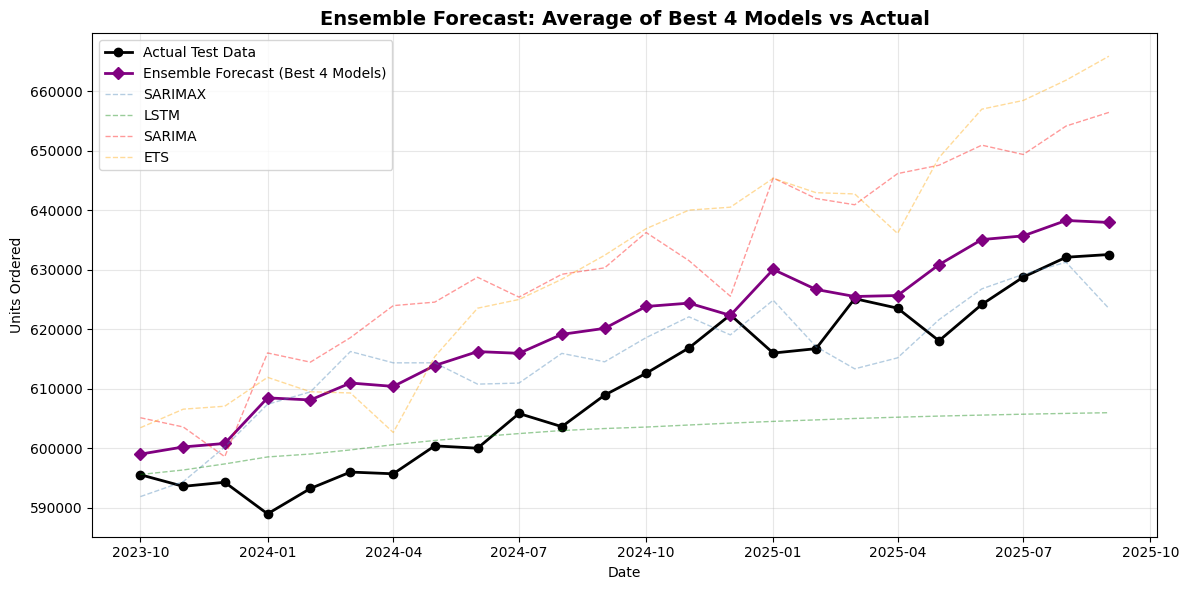

In [17]:
# Ensemble Forecasting - Combine Best 4 Models
# Strategy: Average predictions from top-performing models

# First, identify the best 4 models based on initial evaluation
# Align all forecasts to common dates for fair comparison

# Get common test dates across all models
common_dates = test.index

# Align SARIMAX (typically best performer)
sarimax_aligned = sarimax_forecast.reindex(common_dates)

# Align SARIMA
sarima_aligned = sarima_forecast.reindex(common_dates)

# Align ETS
ets_aligned = ets_forecast_new.reindex(common_dates)

# Align XGBoost (from ML models)
xgb_aligned = xgb_forecast.reindex(common_dates)

# Align LightGBM
lgbm_aligned = lgbm_forecast.reindex(common_dates)

# Align LSTM
lstm_aligned = lstm_forecast.reindex(common_dates)

# Calculate quick RMSE for each to identify best 4
temp_metrics = []
for name, forecast in [
    ('SARIMAX', sarimax_aligned),
    ('SARIMA', sarima_aligned),
    ('ETS', ets_aligned),
    ('XGBoost', xgb_aligned),
    ('LightGBM', lgbm_aligned),
    ('LSTM', lstm_aligned)
]:
    mask = ~(test['Units ordered'].isna() | forecast.isna())
    if mask.sum() > 0:
        rmse = np.sqrt(mean_squared_error(
            test['Units ordered'][mask], 
            forecast[mask]
        ))
        temp_metrics.append({'Model': name, 'RMSE': rmse, 'Forecast': forecast})

# Sort by RMSE and get best 4
temp_metrics.sort(key=lambda x: x['RMSE'])
best_4 = temp_metrics[:4]


for i, model in enumerate(best_4, 1):
    print(f"  {i}. {model['Model']}: RMSE = {model['RMSE']:.2f}")

# Create ensemble forecast (simple average of best 4 models)
ensemble_forecast = pd.Series(0.0, index=common_dates)

for model in best_4:
    forecast_aligned = model['Forecast'].reindex(common_dates).fillna(method='ffill').fillna(method='bfill')
    ensemble_forecast += forecast_aligned / 4

ensemble_forecast.name = 'Ensemble_Forecast'

# Calculate ensemble metrics
ensemble_rmse = np.sqrt(mean_squared_error(test['Units ordered'], ensemble_forecast))
ensemble_mae = mean_absolute_error(test['Units ordered'], ensemble_forecast)
ensemble_mape = mean_absolute_percentage_error(test['Units ordered'], ensemble_forecast) * 100


# Visualization: Ensemble vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='black', linewidth=2, marker='o')
plt.plot(ensemble_forecast.index, ensemble_forecast, label='Ensemble Forecast (Best 4 Models)', color='purple', linewidth=2, marker='D')

# Also plot the 4 individual models for reference
colors = ['steelblue', 'green', 'red', 'orange']
for i, model in enumerate(best_4):
    plt.plot(common_dates, model['Forecast'].reindex(common_dates), 
             label=f"{model['Model']}", linewidth=1, alpha=0.4, linestyle='--', color=colors[i])

plt.title('Ensemble Forecast: Average of Best 4 Models vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Ordered')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Model Comparison
Visual comparison of all forecasting models including ensemble.


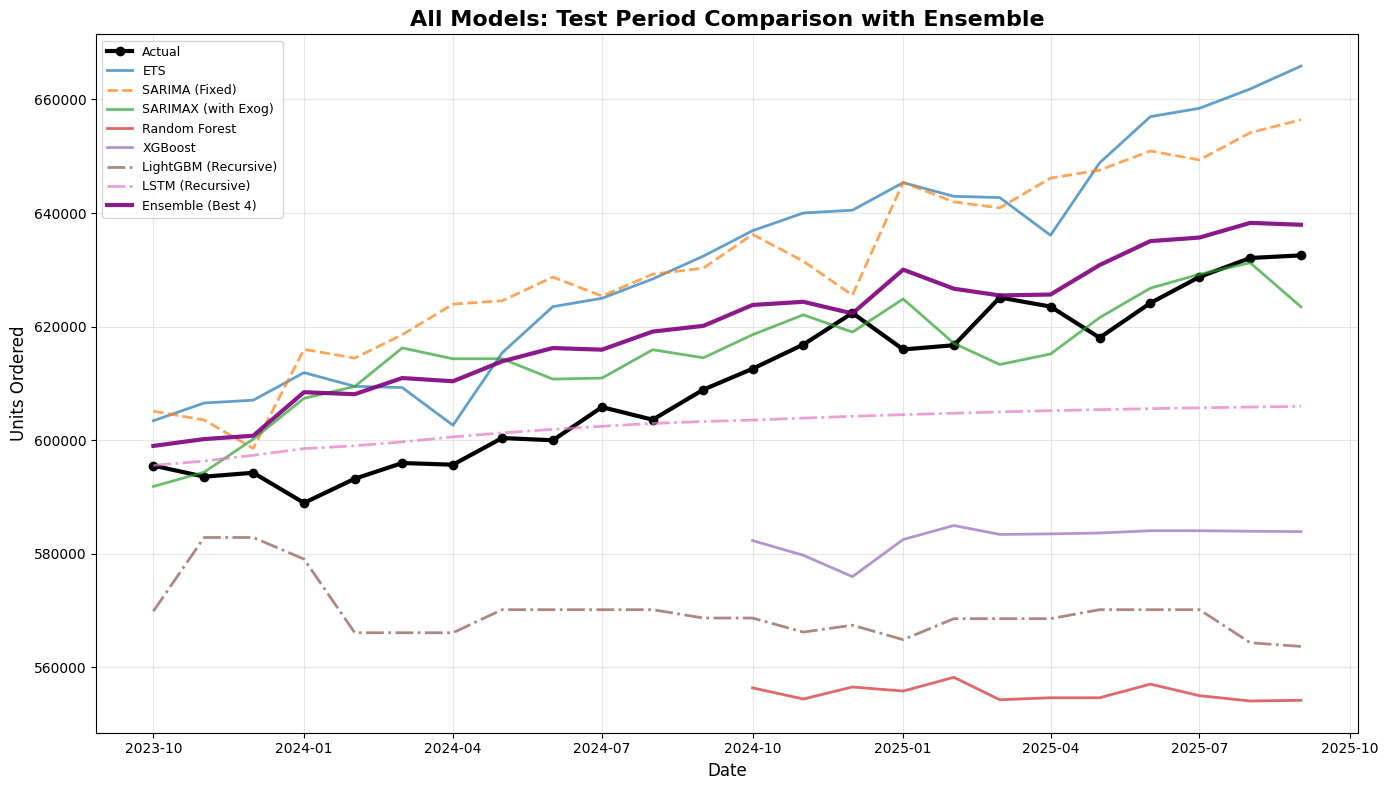

In [18]:
# Model Comparison Chart
# Compare all models on test period

plt.figure(figsize=(14, 8))

# Plot actual data
plt.plot(test.index, test['Units ordered'], label='Actual', color='black', linewidth=3, marker='o')

# Plot traditional models
plt.plot(test.index, ets_forecast_new, label='ETS', linewidth=2, alpha=0.7)
plt.plot(test.index, sarima_forecast, label='SARIMA (Fixed)', linewidth=2, alpha=0.7, linestyle='--')
plt.plot(test.index, sarimax_forecast, label='SARIMAX (with Exog)', linewidth=2, alpha=0.7)

# Plot ML models with recursive forecasting
actual_test_ml = test.loc[y_test_ml.index, 'Units ordered']
plt.plot(y_test_ml.index, rf_forecast, label='Random Forest', linewidth=2, alpha=0.7)
plt.plot(y_test_ml.index, xgb_forecast, label='XGBoost', linewidth=2, alpha=0.7)

# Plot FIXED models (LightGBM and LSTM with recursive forecasting)
plt.plot(lgbm_forecast.index, lgbm_forecast, label='LightGBM (Recursive)', linewidth=2, alpha=0.7, linestyle='-.')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM (Recursive)', linewidth=2, alpha=0.7, linestyle='-.')

# Plot ENSEMBLE model
plt.plot(ensemble_forecast.index, ensemble_forecast, label='Ensemble (Best 4)', linewidth=3, alpha=0.9, color='purple', linestyle='-')

plt.title('All Models: Test Period Comparison with Ensemble', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Ordered', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

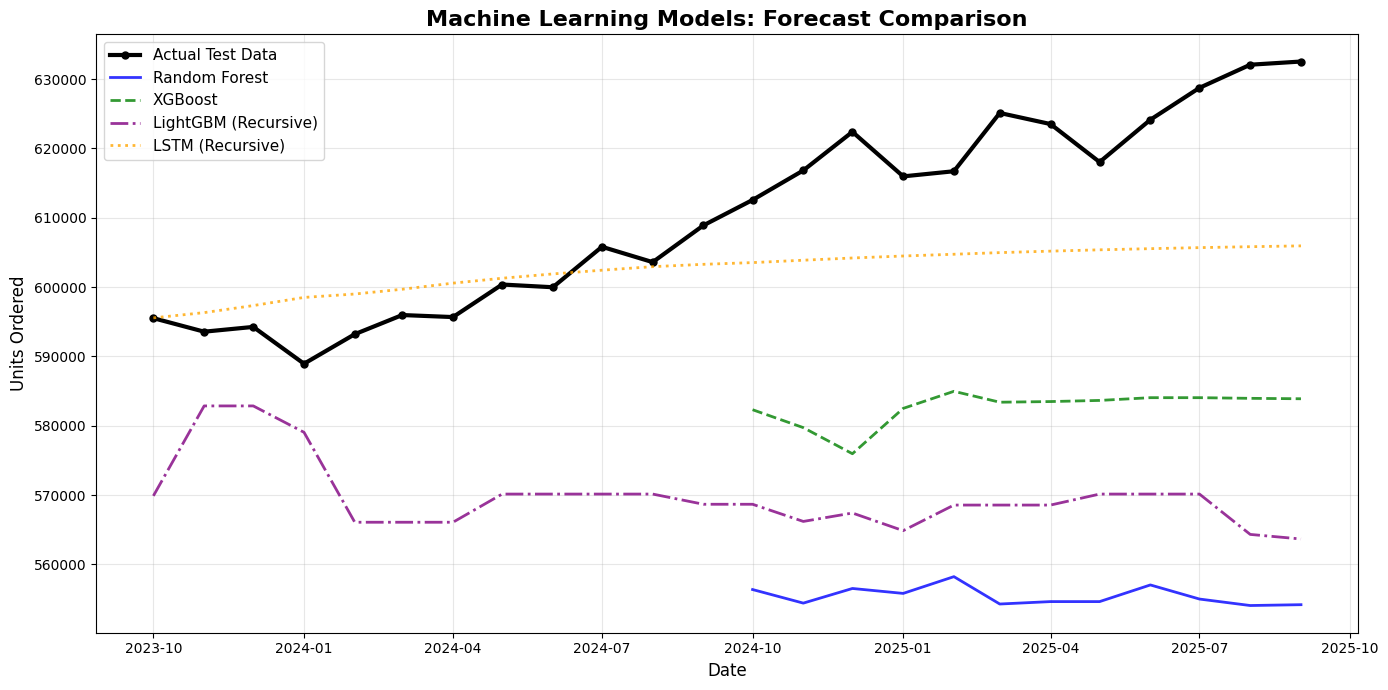

In [22]:
# Machine Learning Models Comparison
# Compare all ML forecasts (Random Forest, XGBoost, LightGBM, LSTM) in one graph

plt.figure(figsize=(14, 7))

# Plot actual test data
plt.plot(test.index, test['Units ordered'], label='Actual Test Data', color='black', linewidth=3, marker='o', markersize=5)

# Plot Random Forest forecast
plt.plot(rf_forecast.index, rf_forecast, label='Random Forest', linewidth=2, alpha=0.8, linestyle='-', color='blue')

# Plot XGBoost forecast
plt.plot(xgb_forecast.index, xgb_forecast, label='XGBoost', linewidth=2, alpha=0.8, linestyle='--', color='green')

# Plot LightGBM forecast (recursive)
plt.plot(lgbm_forecast.index, lgbm_forecast, label='LightGBM (Recursive)', linewidth=2, alpha=0.8, linestyle='-.', color='purple')

# Plot LSTM forecast (recursive)
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM (Recursive)', linewidth=2, alpha=0.8, linestyle=':', color='orange')

plt.title('Machine Learning Models: Forecast Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Ordered', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

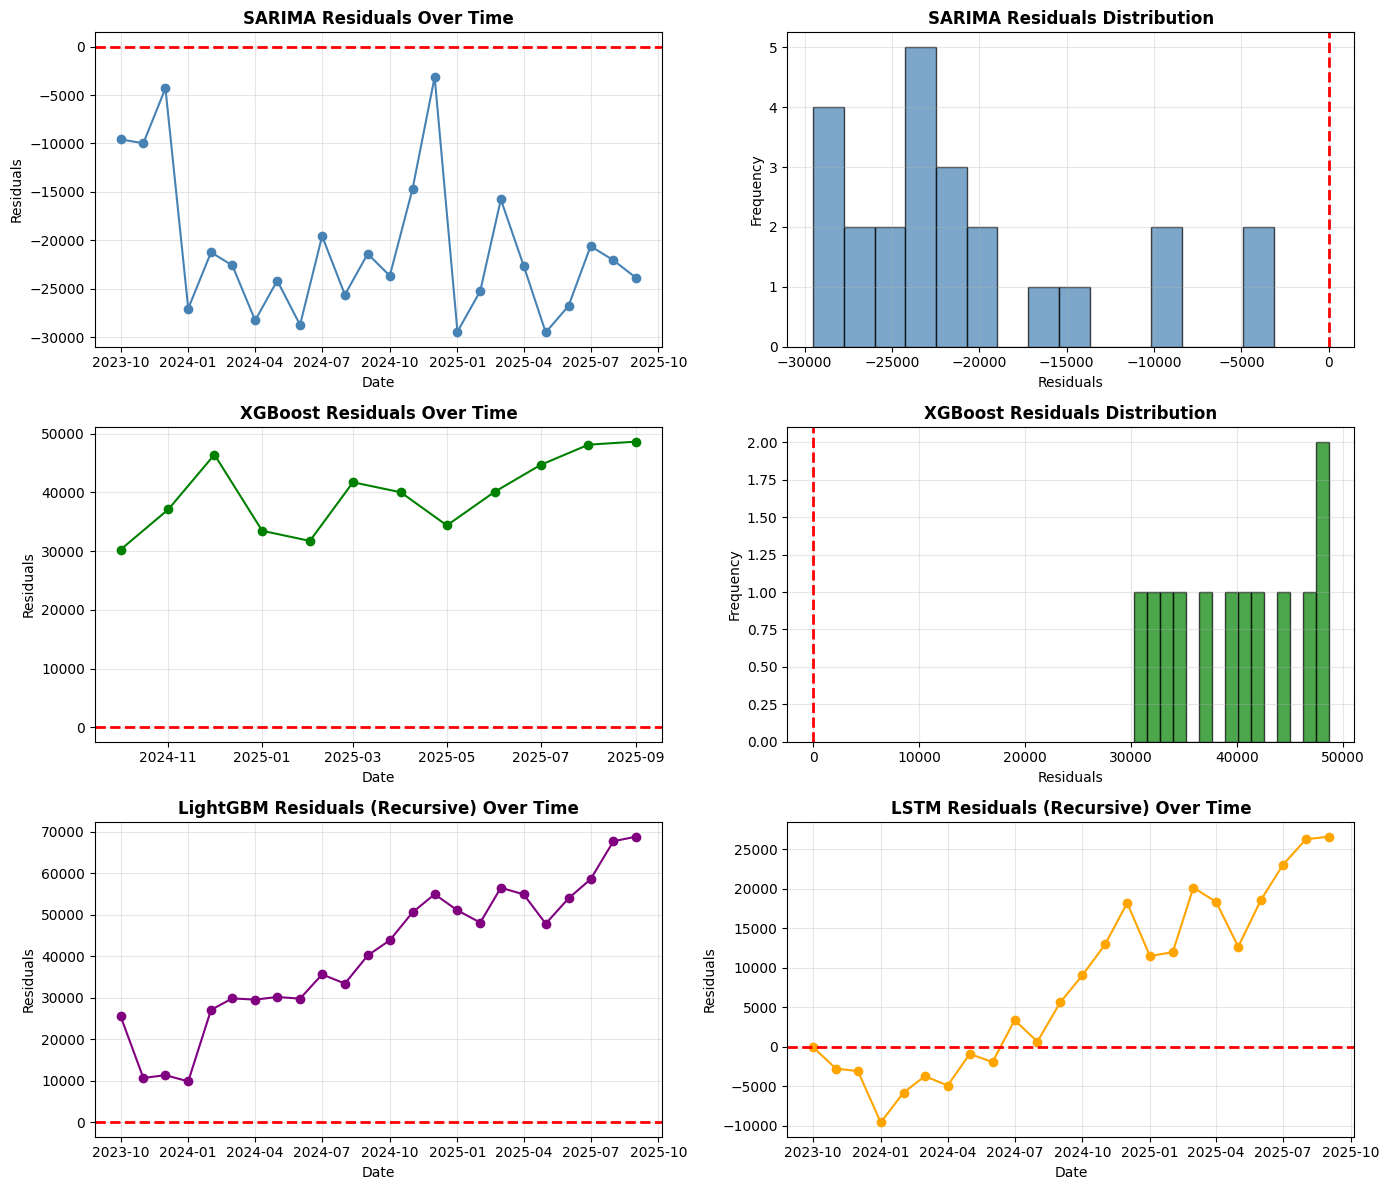

In [19]:
# Residual Analysis for Key Models

# For ML models, use the available test indices
actual_test_ml = test.loc[y_test_ml.index, 'Units ordered']

# Calculate residuals for FIXED models
sarima_residuals = test['Units ordered'] - sarima_forecast
xgb_residuals = actual_test_ml - xgb_forecast

# For recursive forecasts, align properly
lgbm_actual_aligned = test.loc[lgbm_forecast.index, 'Units ordered']
lgbm_residuals = lgbm_actual_aligned - lgbm_forecast

lstm_actual_aligned = test.loc[lstm_forecast.index, 'Units ordered']
lstm_residuals = lstm_actual_aligned - lstm_forecast

# Create comprehensive residual plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# SARIMA residual plot
axes[0, 0].plot(test.index, sarima_residuals, marker='o', linestyle='-', color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('SARIMA Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# SARIMA residual distribution
axes[0, 1].hist(sarima_residuals, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('SARIMA Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# XGBoost residual plot
axes[1, 0].plot(y_test_ml.index, xgb_residuals, marker='o', linestyle='-', color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('XGBoost Residuals Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# XGBoost residual distribution
axes[1, 1].hist(xgb_residuals, bins=15, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('XGBoost Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# LightGBM residual plot (FIXED with recursive forecasting)
axes[2, 0].plot(lgbm_forecast.index, lgbm_residuals, marker='o', linestyle='-', color='purple')
axes[2, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2, 0].set_title('LightGBM Residuals (Recursive) Over Time', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Residuals')
axes[2, 0].grid(True, alpha=0.3)

# LSTM residual plot (FIXED with recursive forecasting)
axes[2, 1].plot(lstm_forecast.index, lstm_residuals, marker='o', linestyle='-', color='orange')
axes[2, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2, 1].set_title('LSTM Residuals (Recursive) Over Time', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Residuals')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Analysis
Analyze residual plots to assess model assumptions and performance.

               Model     RMSE      MAE  MAPE
      SARIMAX (Exog)  9993.09  8010.55  1.32
   Ensemble (Best 4) 11063.78  9784.13  1.61
    LSTM (Recursive) 13322.65 10483.74  1.69
      SARIMA (Fixed) 22108.35 20830.67  3.41
                 ETS 22456.88 21120.74  3.45
             XGBoost 40200.56 39729.33  6.37
LightGBM (Recursive) 43765.23 40465.31  6.58
       Random Forest 67324.19 66960.97 10.75


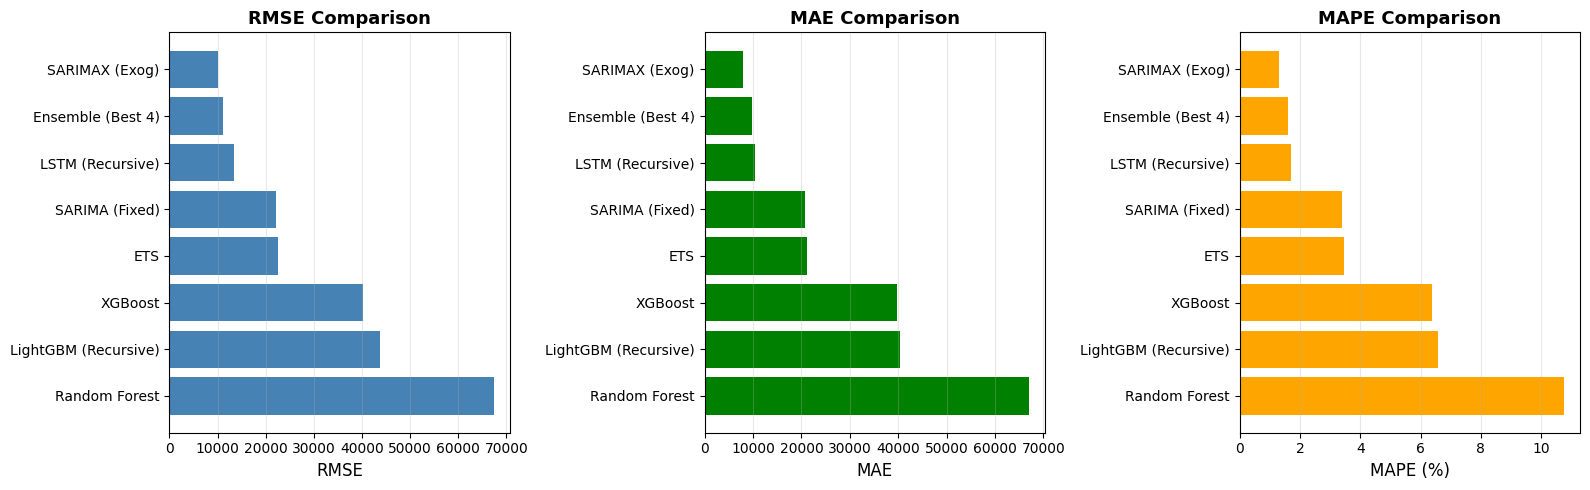

In [20]:
# Model Performance Evaluation - UPDATED WITH ALL FIXES

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def calculate_metrics(actual, forecast, model_name):
    """Calculate key evaluation metrics"""
    # Ensure both are aligned
    if isinstance(actual, pd.Series) and isinstance(forecast, pd.Series):
        actual_aligned = actual.copy()
        forecast_aligned = forecast.reindex(actual.index)
    elif isinstance(actual, pd.Series):
        actual_aligned = actual.copy()
        forecast_aligned = pd.Series(forecast, index=actual.index)
    else:
        actual_aligned = pd.Series(actual)
        forecast_aligned = pd.Series(forecast, index=actual_aligned.index)
    
    # Remove NaN values
    mask = ~(actual_aligned.isna() | forecast_aligned.isna())
    actual_clean = actual_aligned[mask]
    forecast_clean = forecast_aligned[mask]
    
    if len(actual_clean) == 0:
        return {
            'Model': model_name,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan
        }
    
    rmse = np.sqrt(mean_squared_error(actual_clean, forecast_clean))
    mae = mean_absolute_error(actual_clean, forecast_clean)
    mape = mean_absolute_percentage_error(actual_clean, forecast_clean) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Calculate metrics for all models
all_models_metrics = []

# Traditional time series models
all_models_metrics.append(calculate_metrics(test['Units ordered'], ets_forecast_new, 'ETS'))
all_models_metrics.append(calculate_metrics(test['Units ordered'], sarima_forecast, 'SARIMA (Fixed)'))
all_models_metrics.append(calculate_metrics(test['Units ordered'], sarimax_forecast, 'SARIMAX (Exog)'))

# Machine Learning models
actual_test_ml = test.loc[y_test_ml.index, 'Units ordered']
all_models_metrics.append(calculate_metrics(actual_test_ml, rf_forecast, 'Random Forest'))
all_models_metrics.append(calculate_metrics(actual_test_ml, xgb_forecast, 'XGBoost'))

# FIXED ML models with recursive forecasting
lgbm_actual = test.loc[lgbm_forecast.index, 'Units ordered']
all_models_metrics.append(calculate_metrics(lgbm_actual, lgbm_forecast, 'LightGBM (Recursive)'))

lstm_actual = test.loc[lstm_forecast.index, 'Units ordered']
all_models_metrics.append(calculate_metrics(lstm_actual, lstm_forecast, 'LSTM (Recursive)'))

# Ensemble model
all_models_metrics.append(calculate_metrics(test['Units ordered'], ensemble_forecast, 'Ensemble (Best 4)'))

# Create metrics dataframe
metrics_df = pd.DataFrame(all_models_metrics)
metrics_df = metrics_df.round(2)

# Sort by RMSE
metrics_df = metrics_df.sort_values('RMSE')

print(metrics_df.to_string(index=False))

# Visualization: Metric Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE comparison
axes[0].barh(metrics_df['Model'], metrics_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MAE comparison
axes[1].barh(metrics_df['Model'], metrics_df['MAE'], color='green')
axes[1].set_xlabel('MAE', fontsize=12)
axes[1].set_title('MAE Comparison', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# MAPE comparison
axes[2].barh(metrics_df['Model'], metrics_df['MAPE'], color='orange')
axes[2].set_xlabel('MAPE (%)', fontsize=12)
axes[2].set_title('MAPE Comparison', fontsize=13, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()